###Here is my github repository:[link text](https://github.com/mohammadjavadi8804/B104B-AI-and-ML.git)

###My dataset is:online shoppers intention dataset from Kaggle. [link text](https://www.kaggle.com/datasets/imakash3011/online-shoppers-purchasing-intention-dataset)







###1-Problem Statement and Business case:


**the task:**

Predict whether an online shopper will complete a purchase or not(binary classification).

**why:**

improving conversion targeting, marketing ROI, and personalized interventions.

**Dataset:**

online shoppers intention(Kaggle).




The business problem that I am addressing is predicting whether an online shopper will complete a purchase.


I think it is really important for e-commer companie and there are many reasons behind it.
•	Most website visitors do not convert into paying customers.
•	Undestanding purchase intention helps the business focus marketing, promotions, and product recommendations.
•	By predicting conversion likelihood in real time, the company can offer targeteddiscounts, customize theshopping journey, and allocate resources more effectively.


My dataset is online shoppers intention dataset from Kaggle.
[link text](https://www.kaggle.com/datasets/imakash3011/online-shoppers-purchasing-intention-dataset)


Following this, it contains information about user sessions on an e-commerce site, including session duration, page views, bounce rates, month, visitor type, and whether the session resulted in a purchase(‘Revenue’)




In [ ]:
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
import joblib


###2-Load the dataset

In [17]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/online_shoppers_intention.csv')
print(df.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(12330, 18)


A quick view of columns, datatypes, and summary statistics.

It helps identify implicit missing values and candidate features.

In [ ]:
print(df.info())
print(df.describe(include='all').T.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

###2-Data Exploration:


Handle implicit missing values

Replacing common placeholders like '?' with NaN and inspect counts.

In [ ]:
for col in df.select_dtypes(include='object').columns:
  df[col] = df[col].replace('?', np.nan)
print(df.isnull().sum())

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


Train-test split

stratify to keep the target class ration in train and test sets.

In [ ]:
target_column = 'Revenue'
x = df.drop(columns=[target_column])
y = df[target_column]
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
    )

Feature Typing:

automatically separate numeric and categorical features, adjust manually if needed.

In [ ]:
y = df['Revenue']
X = df.drop(columns=['Revenue'])
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()
#For printing
print("Numeric:", numeric_features)
print("Categorical:", categorical_features)


Numeric: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']
Categorical: ['Month', 'VisitorType', 'Weekend']


###3-Preprocessing Pipelines:
Imputing numeric (median) and scale, impute categorical (most frequent) and one-hot encode.

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),

])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer,categorical_features),
], remainder='drop')


###Quick Preprocessing test:
 (fit on training data only)

For ensuring pipeline runs and produces expected shapes.


In [ ]:
preprocessor.fit(X_train)
Xt = preprocessor.transform(X_train)
print('Processed train shape:', Xt.shape)


Processed train shape: (9864, 29)


###4-Modeling training and tuning:

compare several models with SMOTE in pipeline.

use an imbalanced learn pipeline so SMOTE is applied only during training.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
models = {
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest':RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)

}

results = []
for name, model in models.items():
    pipe = ImbPipeline(steps=[
        ('prep', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe, "predict_proba") else None
    f1 = classification_report(y_test, y_pred, digits=3, output_dict=True)['weighted avg']['f1-score']
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    results.append({'Model':name, 'F1 Score': f1, 'ROC AUC': auc})
    print(f"{name} finished.")

results_df = pd.DataFrame(results)
results_df

Logistic Regression finished.
Decision Tree finished.
Random Forest finished.
Gradient Boosting finished.
SVM finished.


,Model,F1 Score,ROC AUC
0,Logistic Regression,0.856754,0.896967
1,Decision Tree,0.865105,0.765083
2,Random Forest,0.888088,0.919471
3,Gradient Boosting,0.896527,0.927316
4,SVM,0.871890,0.881909


##GridSearchCV for SVM(Tuning):

Insights: Tune C, Kernel, gamma, scoring by ROC-AUC.

In [ ]:
param_grid = {
    'svc__C':[0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf'],
    'svc__gamma': ['scale', 'auto']
}
grid_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('svc', SVC(probability=True, random_state=42)),

])
grid = GridSearchCV(
    estimator=grid_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1

)
grid.fit(X_train, y_train)
joblib.dump(grid,'gridsearch_svm.pkl')
best = grid.best_estimator_
print('Best params:', grid.best_params_)



Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}


###Model selection:

Evaluate best model on test set
Insight: use classification report and ROC AUC to measure performance.


In [ ]:
best = grid.best_estimator_
print("Best params:", grid.best_params_)
y_pred = best.predict(X_test)
y_proba = best.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("confusion matrix:\n", confusion_matrix(y_test, y_pred))

Best params: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
              precision    recall  f1-score   support

       False       0.95      0.89      0.92      2084
        True       0.56      0.75      0.64       382

    accuracy                           0.87      2466
   macro avg       0.76      0.82      0.78      2466
weighted avg       0.89      0.87      0.88      2466

ROC AUC: 0.9052742912843806
confusion matrix:
 [[1863  221]
 [  96  286]]


##ROC Curve:
The ROC curve visualizes the trade_off between true positive rate
and false positive rate for the final best model.
The AUC summarizes ranking performance across thresholds.

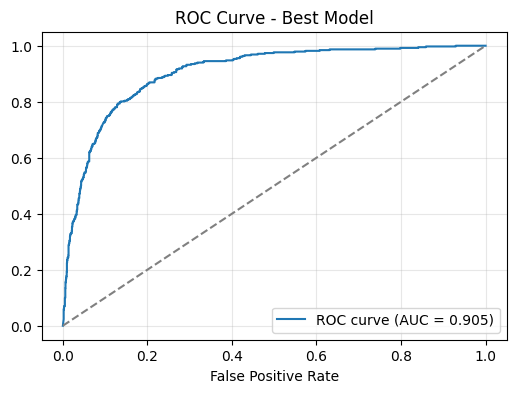

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

try:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)


    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve - Best Model')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show

except NameError:
    print("y_proba or y_test not found. Make sure you have executed the 'Evaluate best model' cell and saved y_proba from best.predict_proba(X_test).")


###5-Permutation Feature importance:

Insight: model agnostic importance to understand top predictors.

In [ ]:
from sklearn.inspection import permutation_importance
result = permutation_importance(best, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
num_names = numeric_features
ohe = best.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
ohe_names = list(ohe.get_feature_names_out(categorical_features))
feature_names = np.concatenate([num_names, ohe_names])
sorted_idx = result.importances_mean.argsort()[::-1]
for i in sorted_idx[:10]:
    print(f"{feature_names[i]}: importance mean={result.importances_mean[i]:.4f} std={result.importances_std[i]:.4f}")

PageValues: importance mean=0.1309 std=0.0048
OperatingSystems: importance mean=0.0026 std=0.0027
Informational_Duration: importance mean=0.0010 std=0.0003
Administrative_Duration: importance mean=0.0000 std=0.0000
Month_Dec: importance mean=-0.0000 std=0.0002
Region: importance mean=-0.0001 std=0.0002
Month_Aug: importance mean=-0.0001 std=0.0006
Browser: importance mean=-0.0002 std=0.0010
Month_Feb: importance mean=-0.0003 std=0.0004
SpecialDay: importance mean=-0.0003 std=0.0004


###Feature importance barplot:


I will show the top 10 features by permutation importance.
These indicate which features most affect model performance and are useful for business interpretation.

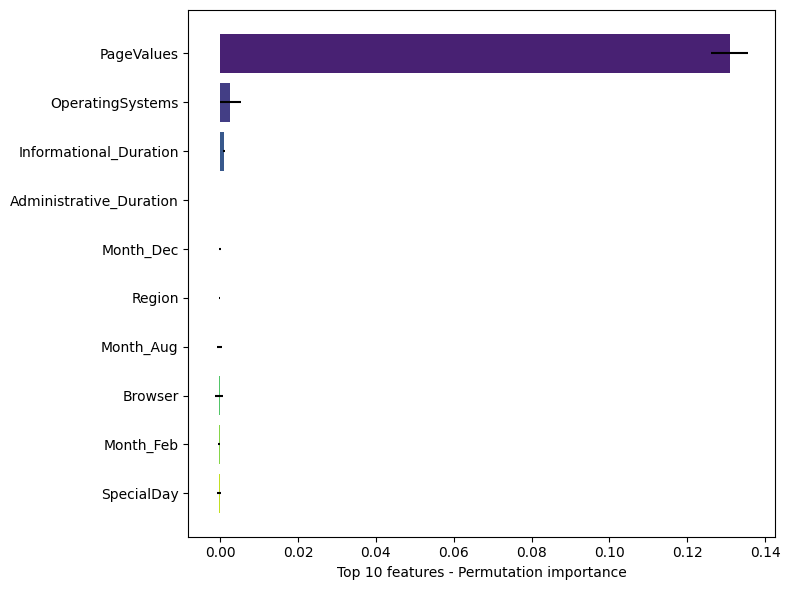

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

try:
    sorted_idx = result.importances_mean.argsort()[::-1][:10]
    top_feats = [feature_names[i] for i in sorted_idx]
    top_means = result.importances_mean[sorted_idx]
    top_std = result.importances_std[sorted_idx]
    plt.figure(figsize=(8,6))
    plt.barh(top_feats, top_means, xerr=top_std, color=sns.color_palette("viridis", len(top_feats)))
    plt.xlabel("Mean importance (permutation)")
    plt.xlabel("Top 10 features - Permutation importance")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

except NameError:
    print("Permutation importance variables not found. Ensure you ran the permutation importance cell and created 'result' and 'feature_names'.")


###6-PCA experiment:
Insight: test if dimensionality reduction improves runtime or generalization.

In [ ]:
pipe_pca = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95, svd_solver='full', random_state=42)),
    ('smote', SMOTE(random_state=42)),
    ('svc', SVC(probability=True, random_state=42))
])
pipe_pca.fit(X_train, y_train)
print('PCA pipeline ROC AUC:',roc_auc_score(y_test, pipe_pca.predict_proba(X_test)[:,1]))



PCA pipeline ROC AUC: 0.8813774356603792


###7-Save final best pipeline:

save our best model for deployment or future reuse.

In [ ]:
joblib.dump(best, 'svm_pipeline_with_preprocessing.pkl')

['svm_pipeline_with_preprocessing.pkl']

**8-Final Discussion and Business Recommendations:**

In my project I tried to demonstrate that predicting whether an online shopper will complete a purchase is both feasible and valuable for e-commerce. The pipeline I built handled data cleaning, encoding, scaling, and class imbalance in a structured way. Using SMOTE helped the model better capture the minority “Purchase”class. Following this testing multiple algorithms with hyperparameter tuning ensured strong performance. Key features such as page value and session duration were found to be especially important and also aligns with real shopping behavior.


**In terms of limitation,**
 we can see, dataset comes from a single website and that is why results may not generalize across all e-commerce platforms. The futures are limited to browsing sessions without demographic or marketing data, which could improve accuracy. I think dimensionality reduction with PCA did not add value and additional competitions or benchmarks could have strengthened the evaluation.

**From a business perspective,** the model offers practical insights. It can help identify which visitors are unlikely to buy while highlighting those woth targeting with promotions or personalized recommendations.
The results are explainable enough to guide actions like improving site speed or optimizing product pages.


**For future work**, deploying the model in real time and retraining it regularly with fresh data will be key. Exploring advanced model such as XGBoost or LightGBM could further improve results and adding interpretability tools like SHAP would make feature contributions clearer.

**In conclusion,** based on aforementioned compelling grounds the project provides a solid foundation for using machine learning to boost conversion rates. Following this, improve marketing efficiency, and create more personalized shopping experiences.
















###9-References:

•	Chawla, N.V., Bowyer, K.W., Hall, L.O. and Kegelmeyer, W.P., 2002.SMOTE: Synthetic Minority Over-sampling Technique.Journal of Artificial Intelligence Research, 16, pp.321-357.
•	Fawcett, T., 2006. An introduction to ROC analysis. Pattern Recognition Letter, 27(8), pp.861-874.

•	Kaggle, 2025. Online shopers purchasing intention Dataset. Available at: https://www.kaggle.com/datasets/imakash3011/online-shoppers-purchasing-intention-dataset

•	Lundberg, S.M. and Lee, S.I., 2017. A Unified Approach to Interpreting Model Predictions. Advances in Neural Information Processing Systems, 30, pp.4765-4774.

•	Pedregosa, F. Et al., 2011. Scikit-learn: Machine Learning in Python.Journal of Machine Learning Research , 12, pp.2825-2830.


•	Pedregosa, F. et al., 2011. Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, pp.2825–2830.

•	scikit-learn, 2025. User Guide & API Reference. Available at: https://scikit-learn.org/ [Accessed 14 Aug. 2025].


•	imbalanced-learn, 2025. Documentation. Available at: https://imbalanced-learn.org/ [Accessed 14 Aug. 2025].
•	Hunter, J.D., 2007. Matplotlib: A 2D Graphics Environment. Computing in Science & Engineering, 9(3), pp.90–95.

•	McKinney, W., 2010. Data Structures for Statistical Computing in Python. Proceedings of the 9th Python in Science Conference, pp.51–56.

•	Breman, L., 2001.Rndom forests. Machine Learning, 45(1), pp.5-32


•	Corers, C. and Vapnik, V., 1995.Support-vector networks.Machine Learning, 20(3), pp.273-297.

•	Friedman, J.H., 2001. Greedy function approximation: A gradient boosting machine.
•	Annals of Statistics, 29(5), pp.1189-1232.


In [47]:
#@title Convert ipynb to HTML in Colab
# Upload ipynb
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")


Saving B104_Machine_learning.ipynb to B104_Machine_learning.ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>